# Fractional Calculus: Derivatives of Arbitrary Order

## Introduction

Fractional calculus extends the classical notions of differentiation and integration to non-integer orders. While traditional calculus answers questions like "What is the first derivative?" or "What is the second derivative?", fractional calculus asks: **What is the half-derivative?** Or more generally, **what is the $\alpha$-th derivative for any real $\alpha$?**

This field, with roots tracing back to correspondence between Leibniz and L'Hôpital in 1695, has found modern applications in:
- **Viscoelastic materials** (memory-dependent stress-strain relationships)
- **Anomalous diffusion** (subdiffusion and superdiffusion processes)
- **Control theory** (PID controllers with fractional orders)
- **Signal processing** (fractional filters and edge detection)

---

## Mathematical Foundations

### The Gamma Function: Generalizing Factorials

The factorial function $n! = n \cdot (n-1) \cdot \ldots \cdot 2 \cdot 1$ is defined only for non-negative integers. To extend derivatives to non-integer orders, we need a continuous generalization. The **Gamma function** provides this:

$$\Gamma(z) = \int_0^\infty t^{z-1} e^{-t} \, dt, \quad \text{Re}(z) > 0$$

Key properties:
- $\Gamma(n+1) = n!$ for non-negative integers $n$
- $\Gamma(z+1) = z \cdot \Gamma(z)$ (functional equation)
- $\Gamma(1/2) = \sqrt{\pi}$

---

### Riemann-Liouville Fractional Derivative

The **Riemann-Liouville (RL) fractional derivative** of order $\alpha > 0$ is defined as:

$${}^{RL}D_a^\alpha f(x) = \frac{1}{\Gamma(n-\alpha)} \frac{d^n}{dx^n} \int_a^x (x-t)^{n-\alpha-1} f(t) \, dt$$

where $n = \lceil \alpha \rceil$ (the smallest integer greater than or equal to $\alpha$).

For $0 < \alpha < 1$, this simplifies to:

$${}^{RL}D_a^\alpha f(x) = \frac{1}{\Gamma(1-\alpha)} \frac{d}{dx} \int_a^x (x-t)^{-\alpha} f(t) \, dt$$

---

### Grünwald-Letnikov Fractional Derivative

The **Grünwald-Letnikov (GL) definition** provides a discrete approximation ideal for numerical computation:

$${}^{GL}D^\alpha f(x) = \lim_{h \to 0} \frac{1}{h^\alpha} \sum_{k=0}^{\lfloor (x-a)/h \rfloor} (-1)^k \binom{\alpha}{k} f(x - kh)$$

where the **generalized binomial coefficient** is:

$$\binom{\alpha}{k} = \frac{\Gamma(\alpha + 1)}{\Gamma(k + 1) \Gamma(\alpha - k + 1)} = \frac{\alpha (\alpha-1) \cdots (\alpha-k+1)}{k!}$$

For computational purposes, we use the recursive relation:

$$w_k^{(\alpha)} = (-1)^k \binom{\alpha}{k} = w_{k-1}^{(\alpha)} \cdot \frac{k - 1 - \alpha}{k}, \quad w_0^{(\alpha)} = 1$$

---

### Caputo Fractional Derivative

The **Caputo derivative** reverses the order of differentiation and integration:

$${}^{C}D_a^\alpha f(x) = \frac{1}{\Gamma(n-\alpha)} \int_a^x (x-t)^{n-\alpha-1} f^{(n)}(t) \, dt$$

**Advantage**: The Caputo derivative of a constant is zero, matching classical calculus intuition and making it preferred for initial value problems.

---

### Key Example: Fractional Derivative of Power Functions

For $f(x) = x^\beta$ with $\beta > -1$ and $\alpha > 0$:

$${}^{RL}D_0^\alpha x^\beta = \frac{\Gamma(\beta + 1)}{\Gamma(\beta - \alpha + 1)} x^{\beta - \alpha}$$

This elegant formula shows that fractional differentiation *shifts* the power by $\alpha$ and *scales* by a ratio of Gamma functions.

**Special case**: For $f(x) = x$ and $\alpha = 1/2$:

$$D^{1/2} x = \frac{\Gamma(2)}{\Gamma(3/2)} x^{1/2} = \frac{1}{\sqrt{\pi}/2} \sqrt{x} = \frac{2\sqrt{x}}{\sqrt{\pi}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.integrate import quad

# Set up publication-quality plotting
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'figure.figsize': (12, 10),
    'lines.linewidth': 2
})

## Implementation: Grünwald-Letnikov Fractional Derivative

We implement the GL definition using the efficient recursive formula for weights. This approach is numerically stable and computationally efficient.

In [2]:
def grunwald_letnikov_weights(alpha, n):
    """
    Compute Grünwald-Letnikov weights using the recursive formula.
    
    Parameters:
    -----------
    alpha : float
        Order of the fractional derivative
    n : int
        Number of weights to compute
    
    Returns:
    --------
    weights : ndarray
        Array of GL weights w_k = (-1)^k * C(alpha, k)
    """
    weights = np.zeros(n)
    weights[0] = 1.0
    
    for k in range(1, n):
        weights[k] = weights[k-1] * (k - 1 - alpha) / k
    
    return weights


def fractional_derivative_gl(f, x, alpha, h=None, a=0):
    """
    Compute the Grünwald-Letnikov fractional derivative of order alpha.
    
    Parameters:
    -----------
    f : callable
        Function to differentiate
    x : float or ndarray
        Point(s) at which to evaluate the derivative
    alpha : float
        Order of the fractional derivative
    h : float, optional
        Step size (default: adaptive based on x)
    a : float
        Lower terminal of differentiation
    
    Returns:
    --------
    result : float or ndarray
        Fractional derivative evaluated at x
    """
    x = np.atleast_1d(x)
    result = np.zeros_like(x, dtype=float)
    
    for i, xi in enumerate(x):
        if xi <= a:
            result[i] = 0.0
            continue
            
        # Adaptive step size
        if h is None:
            h_use = (xi - a) / 500  # Use 500 points
        else:
            h_use = h
        
        n = int(np.floor((xi - a) / h_use)) + 1
        weights = grunwald_letnikov_weights(alpha, n)
        
        # Evaluate function at shifted points
        points = xi - np.arange(n) * h_use
        f_vals = np.array([f(p) for p in points])
        
        # Compute weighted sum
        result[i] = np.sum(weights * f_vals) / (h_use ** alpha)
    
    return result if len(result) > 1 else result[0]


# Verify implementation: analytical vs numerical for f(x) = x^2
def analytical_power_derivative(x, beta, alpha):
    """
    Analytical fractional derivative of x^beta.
    D^alpha(x^beta) = Gamma(beta+1) / Gamma(beta-alpha+1) * x^(beta-alpha)
    """
    if x <= 0:
        return 0.0
    coeff = gamma(beta + 1) / gamma(beta - alpha + 1)
    return coeff * (x ** (beta - alpha))


# Test with f(x) = x^2, alpha = 0.5
x_test = np.linspace(0.1, 2, 20)
numerical = fractional_derivative_gl(lambda x: x**2, x_test, 0.5)
analytical = np.array([analytical_power_derivative(xi, 2, 0.5) for xi in x_test])

print("Verification: D^{0.5}(x^2)")
print(f"Max relative error: {np.max(np.abs(numerical - analytical) / analytical) * 100:.4f}%")

Verification: D^{0.5}(x^2)
Max relative error: 0.0750%


## Visualization 1: Fractional Derivatives of $f(x) = x^2$

We visualize how derivatives of different orders $\alpha \in \{0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0\}$ transform the parabola $x^2$. This demonstrates the smooth interpolation between integer-order derivatives.

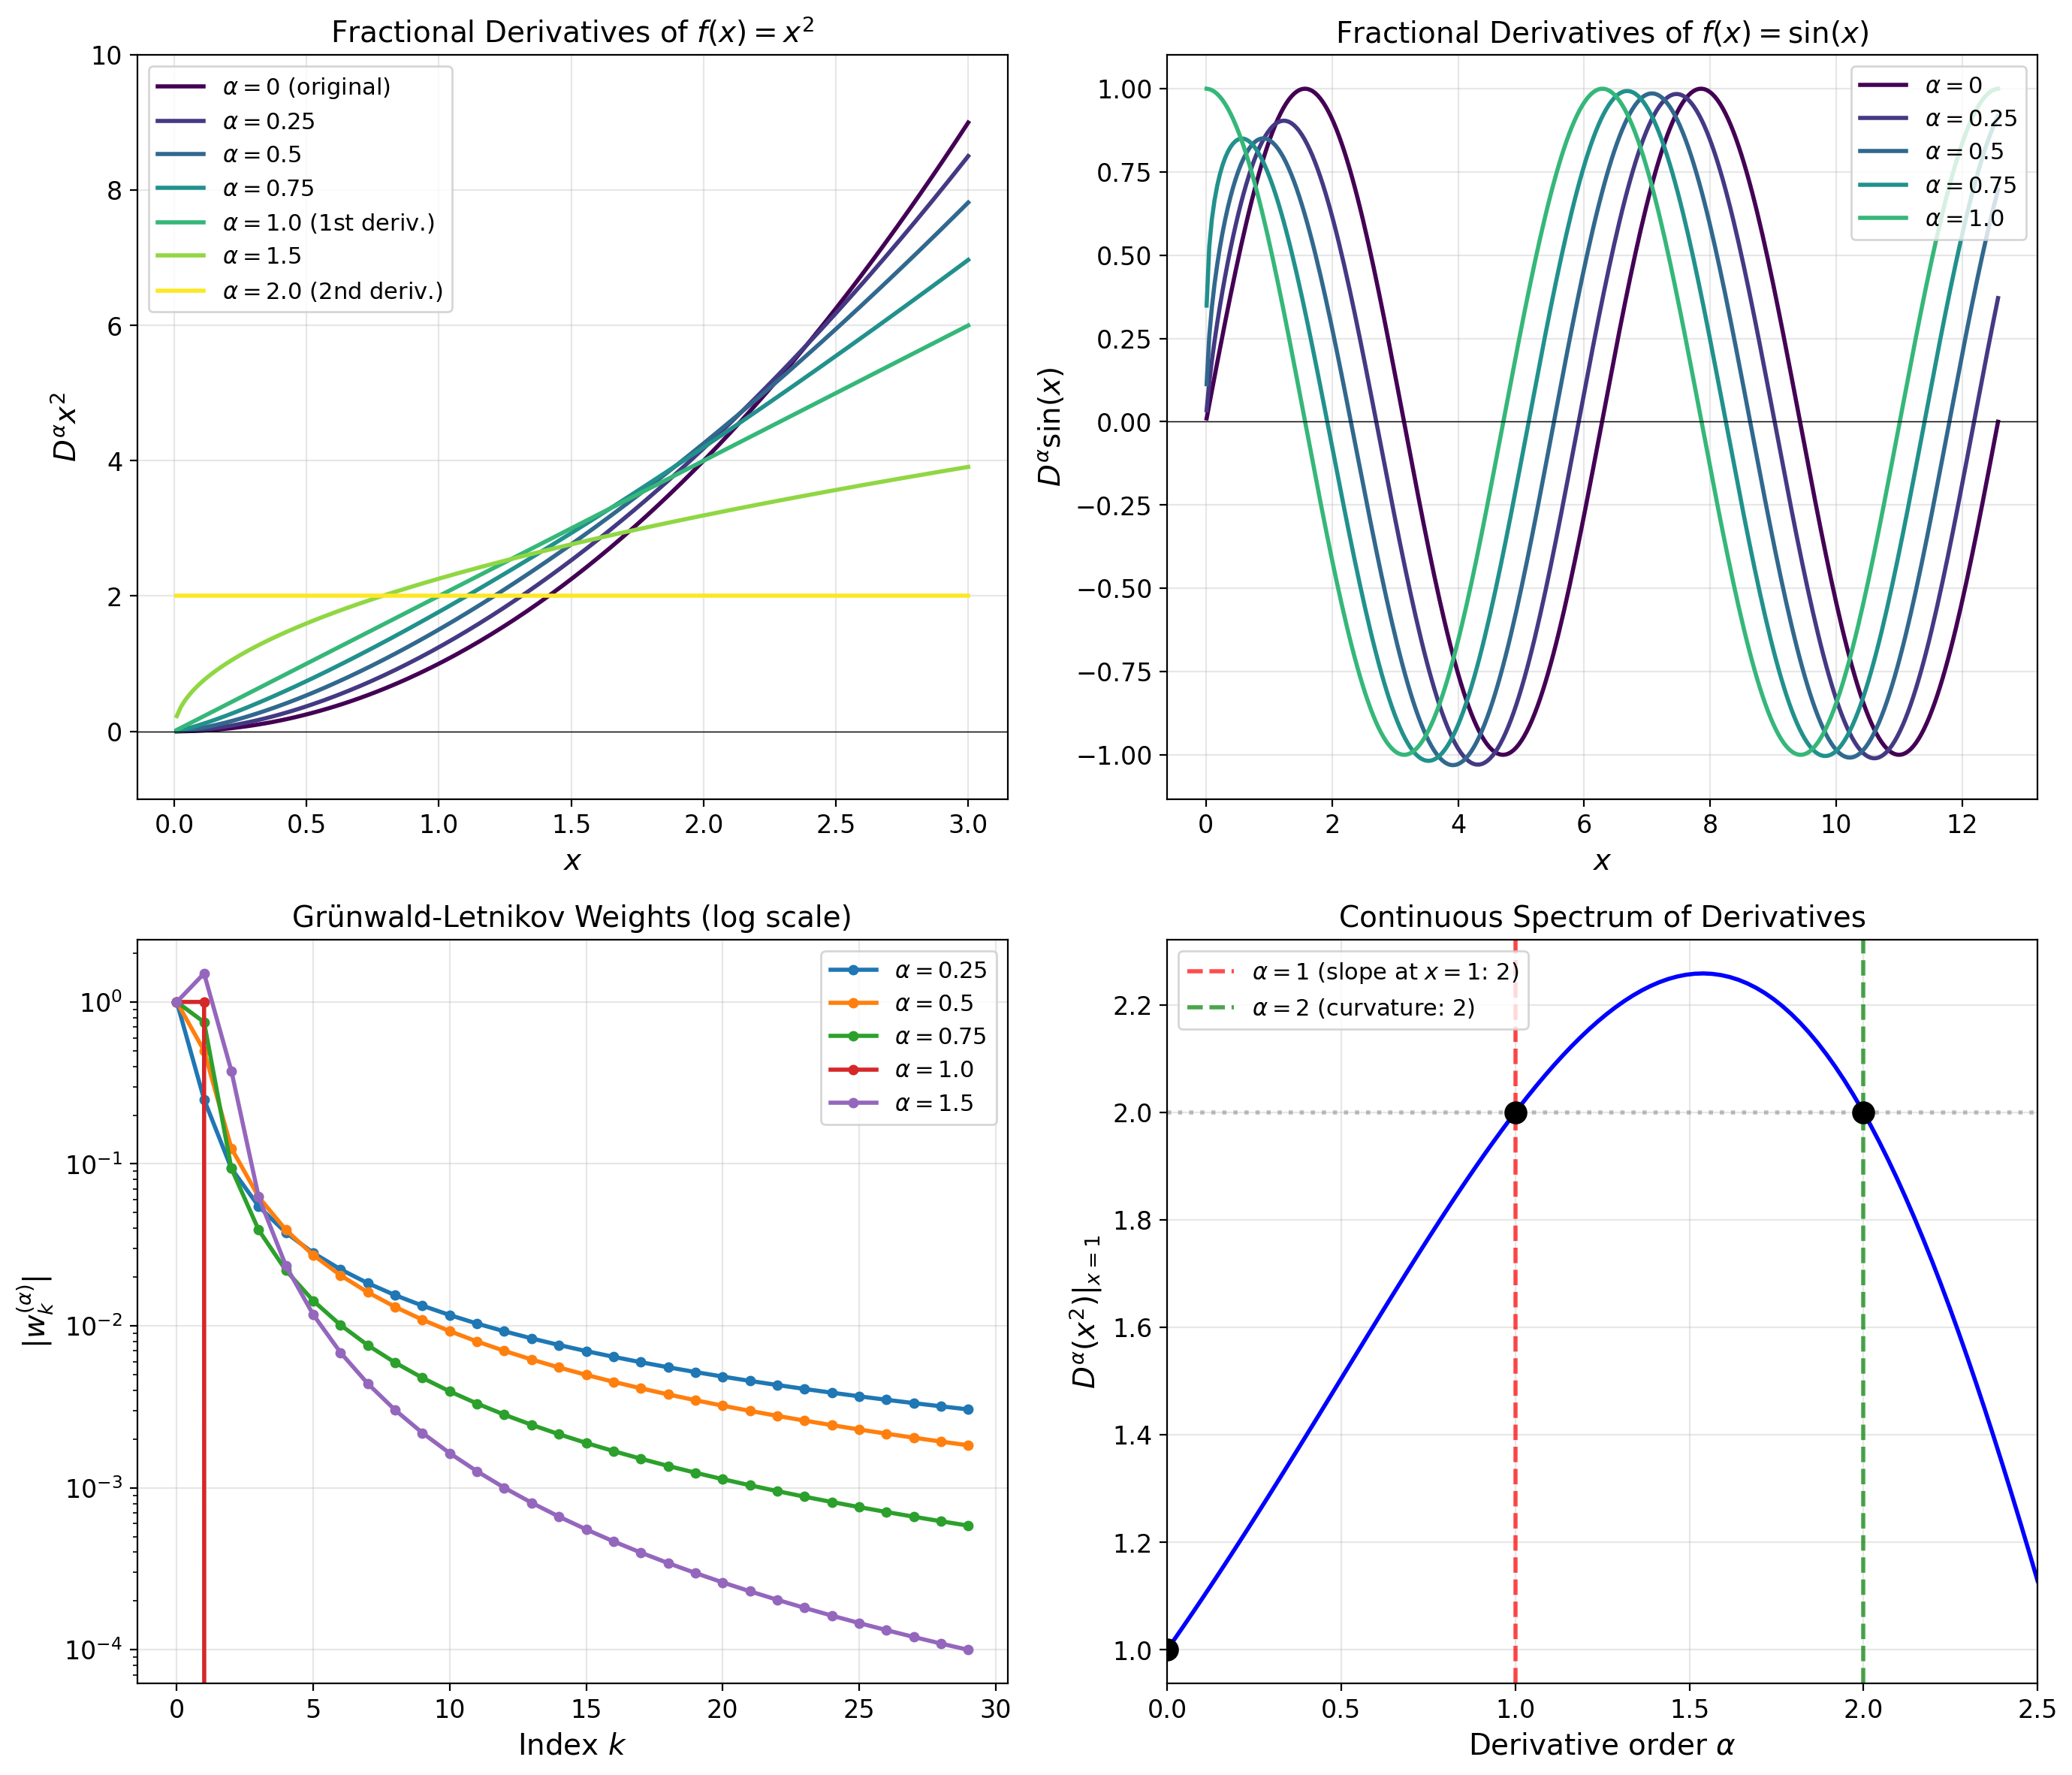


Plot saved to plot.png


In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel 1: Fractional derivatives of x^2
ax1 = axes[0, 0]
x = np.linspace(0.01, 3, 200)
alphas = [0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))

for alpha, color in zip(alphas, colors):
    y = np.array([analytical_power_derivative(xi, 2, alpha) for xi in x])
    label = f'$\\alpha = {alpha}$'
    if alpha == 0:
        label += ' (original)'
    elif alpha == 1:
        label += ' (1st deriv.)'
    elif alpha == 2:
        label += ' (2nd deriv.)'
    ax1.plot(x, y, color=color, label=label, linewidth=2)

ax1.set_xlabel('$x$')
ax1.set_ylabel('$D^{\\alpha} x^2$')
ax1.set_title('Fractional Derivatives of $f(x) = x^2$')
ax1.legend(loc='upper left')
ax1.set_ylim(-1, 10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# Panel 2: Fractional derivatives of sin(x)
ax2 = axes[0, 1]
x = np.linspace(0.01, 4*np.pi, 300)
alphas_sin = [0, 0.25, 0.5, 0.75, 1.0]

for alpha, color in zip(alphas_sin, colors[:len(alphas_sin)]):
    y = fractional_derivative_gl(np.sin, x, alpha)
    label = f'$\\alpha = {alpha}$'
    ax2.plot(x, y, color=color, label=label, linewidth=2)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$D^{\\alpha} \\sin(x)$')
ax2.set_title('Fractional Derivatives of $f(x) = \\sin(x)$')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# Panel 3: Grünwald-Letnikov weights
ax3 = axes[1, 0]
k_vals = np.arange(0, 30)
alphas_w = [0.25, 0.5, 0.75, 1.0, 1.5]

for alpha in alphas_w:
    weights = grunwald_letnikov_weights(alpha, 30)
    ax3.semilogy(k_vals, np.abs(weights), 'o-', label=f'$\\alpha = {alpha}$', markersize=4)

ax3.set_xlabel('Index $k$')
ax3.set_ylabel('$|w_k^{(\\alpha)}|$')
ax3.set_title('Grünwald-Letnikov Weights (log scale)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Panel 4: Derivative order vs function value at x=1 for x^2
ax4 = axes[1, 1]
alpha_range = np.linspace(0, 2.5, 100)
x_eval = 1.0

# For x^2 at x=1: D^alpha(x^2)|_{x=1} = Gamma(3)/Gamma(3-alpha)
deriv_at_1 = np.array([gamma(3) / gamma(3 - a) for a in alpha_range])

ax4.plot(alpha_range, deriv_at_1, 'b-', linewidth=2)
ax4.axvline(x=1, color='r', linestyle='--', alpha=0.7, label='$\\alpha=1$ (slope at $x=1$: 2)')
ax4.axvline(x=2, color='g', linestyle='--', alpha=0.7, label='$\\alpha=2$ (curvature: 2)')
ax4.axhline(y=2, color='gray', linestyle=':', alpha=0.5)

# Mark integer derivative values
ax4.plot([0, 1, 2], [1, 2, 2], 'ko', markersize=10, zorder=5)

ax4.set_xlabel('Derivative order $\\alpha$')
ax4.set_ylabel('$D^{\\alpha}(x^2)|_{x=1}$')
ax4.set_title('Continuous Spectrum of Derivatives')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 2.5)

plt.tight_layout()
plt.savefig('fractional_calculus_derivatives_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to plot.png")

## Application: Fractional Relaxation Equation

The fractional relaxation equation generalizes exponential decay:

$${}^{C}D_0^\alpha y(t) + \lambda y(t) = 0, \quad y(0) = y_0$$

For $\alpha = 1$, this yields the classical exponential decay $y(t) = y_0 e^{-\lambda t}$.

For $0 < \alpha < 1$, the solution involves the **Mittag-Leffler function**:

$$y(t) = y_0 E_\alpha(-\lambda t^\alpha)$$

where

$$E_\alpha(z) = \sum_{k=0}^\infty \frac{z^k}{\Gamma(\alpha k + 1)}$$

The Mittag-Leffler function interpolates between:
- $E_1(z) = e^z$ (exponential)
- $E_2(z^2) = \cosh(z)$ (hyperbolic cosine)

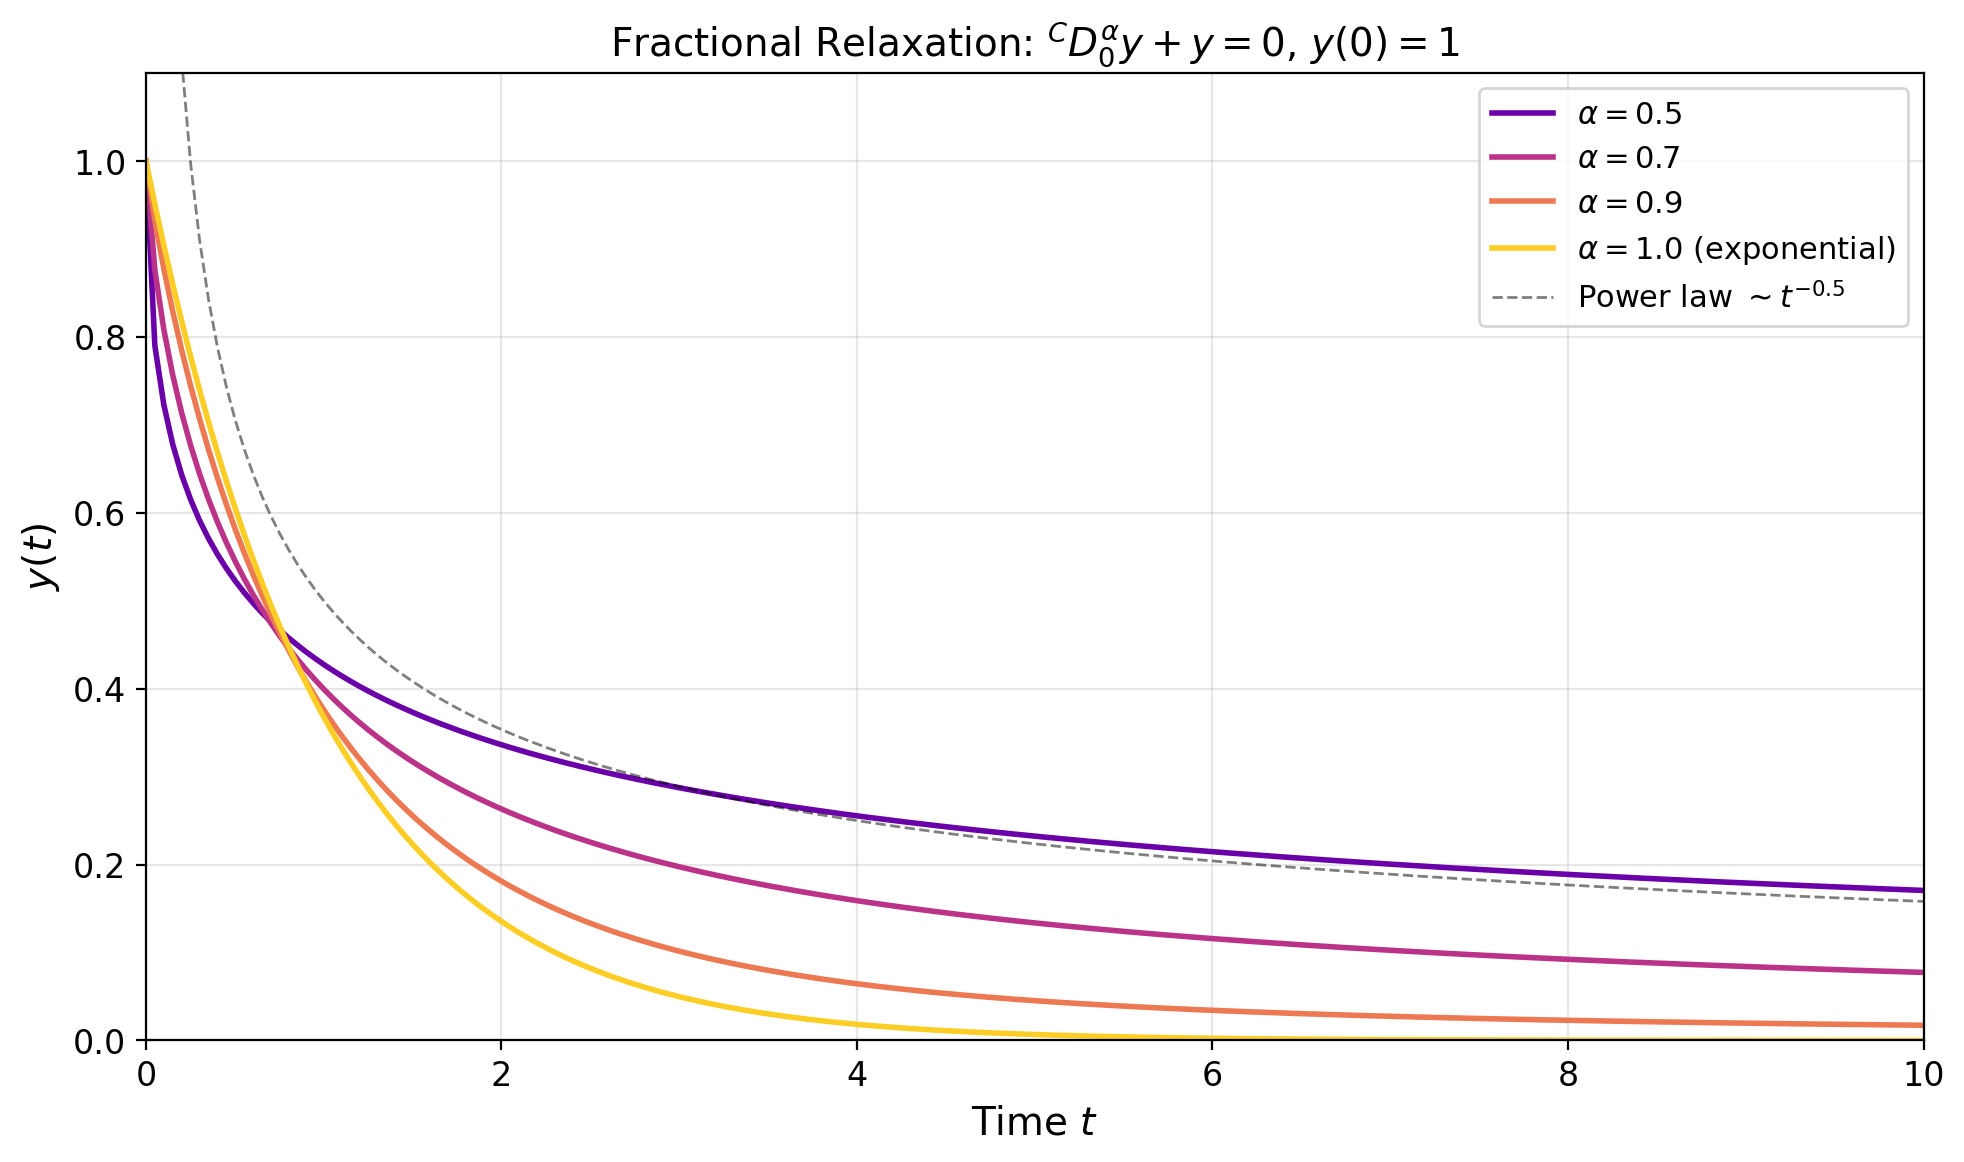


Note: For alpha < 1, the relaxation exhibits power-law tails (slower than exponential).
This 'memory effect' is characteristic of fractional dynamics.


In [4]:
def mittag_leffler(z, alpha, beta=1.0, n_terms=100):
    """
    Compute the generalized Mittag-Leffler function E_{alpha,beta}(z).
    
    E_{alpha,beta}(z) = sum_{k=0}^{infty} z^k / Gamma(alpha*k + beta)
    
    Parameters:
    -----------
    z : float or ndarray
        Argument
    alpha : float
        First parameter (> 0)
    beta : float
        Second parameter (default: 1.0)
    n_terms : int
        Number of terms in series
    
    Returns:
    --------
    result : float or ndarray
    """
    z = np.atleast_1d(z)
    result = np.zeros_like(z, dtype=float)
    
    for i, zi in enumerate(z):
        total = 0.0
        for k in range(n_terms):
            term = (zi ** k) / gamma(alpha * k + beta)
            total += term
            if np.abs(term) < 1e-15:
                break
        result[i] = total
    
    return result if len(result) > 1 else result[0]


# Compare fractional relaxation for different alpha values
t = np.linspace(0, 10, 200)
lam = 1.0  # Relaxation rate
y0 = 1.0   # Initial condition

plt.figure(figsize=(10, 6))

alphas_relax = [0.5, 0.7, 0.9, 1.0]
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(alphas_relax)))

for alpha, color in zip(alphas_relax, colors):
    if alpha == 1.0:
        y = y0 * np.exp(-lam * t)
        label = f'$\\alpha = 1.0$ (exponential)'
    else:
        y = y0 * mittag_leffler(-lam * t**alpha, alpha)
        label = f'$\\alpha = {alpha}$'
    
    plt.plot(t, y, color=color, linewidth=2, label=label)

# Add power-law reference
t_power = t[t > 0.1]
plt.plot(t_power, 0.5 / t_power**0.5, 'k--', alpha=0.5, linewidth=1, 
         label=r'Power law $\sim t^{-0.5}$')

plt.xlabel('Time $t$')
plt.ylabel('$y(t)$')
plt.title('Fractional Relaxation: ${}^CD_0^\\alpha y + y = 0$, $y(0) = 1$')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 10)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("\nNote: For alpha < 1, the relaxation exhibits power-law tails (slower than exponential).")
print("This 'memory effect' is characteristic of fractional dynamics.")

## Numerical Convergence Analysis

We verify the convergence of our Grünwald-Letnikov implementation by examining the error as a function of step size $h$. The GL scheme is expected to have first-order convergence: error $\sim O(h)$.

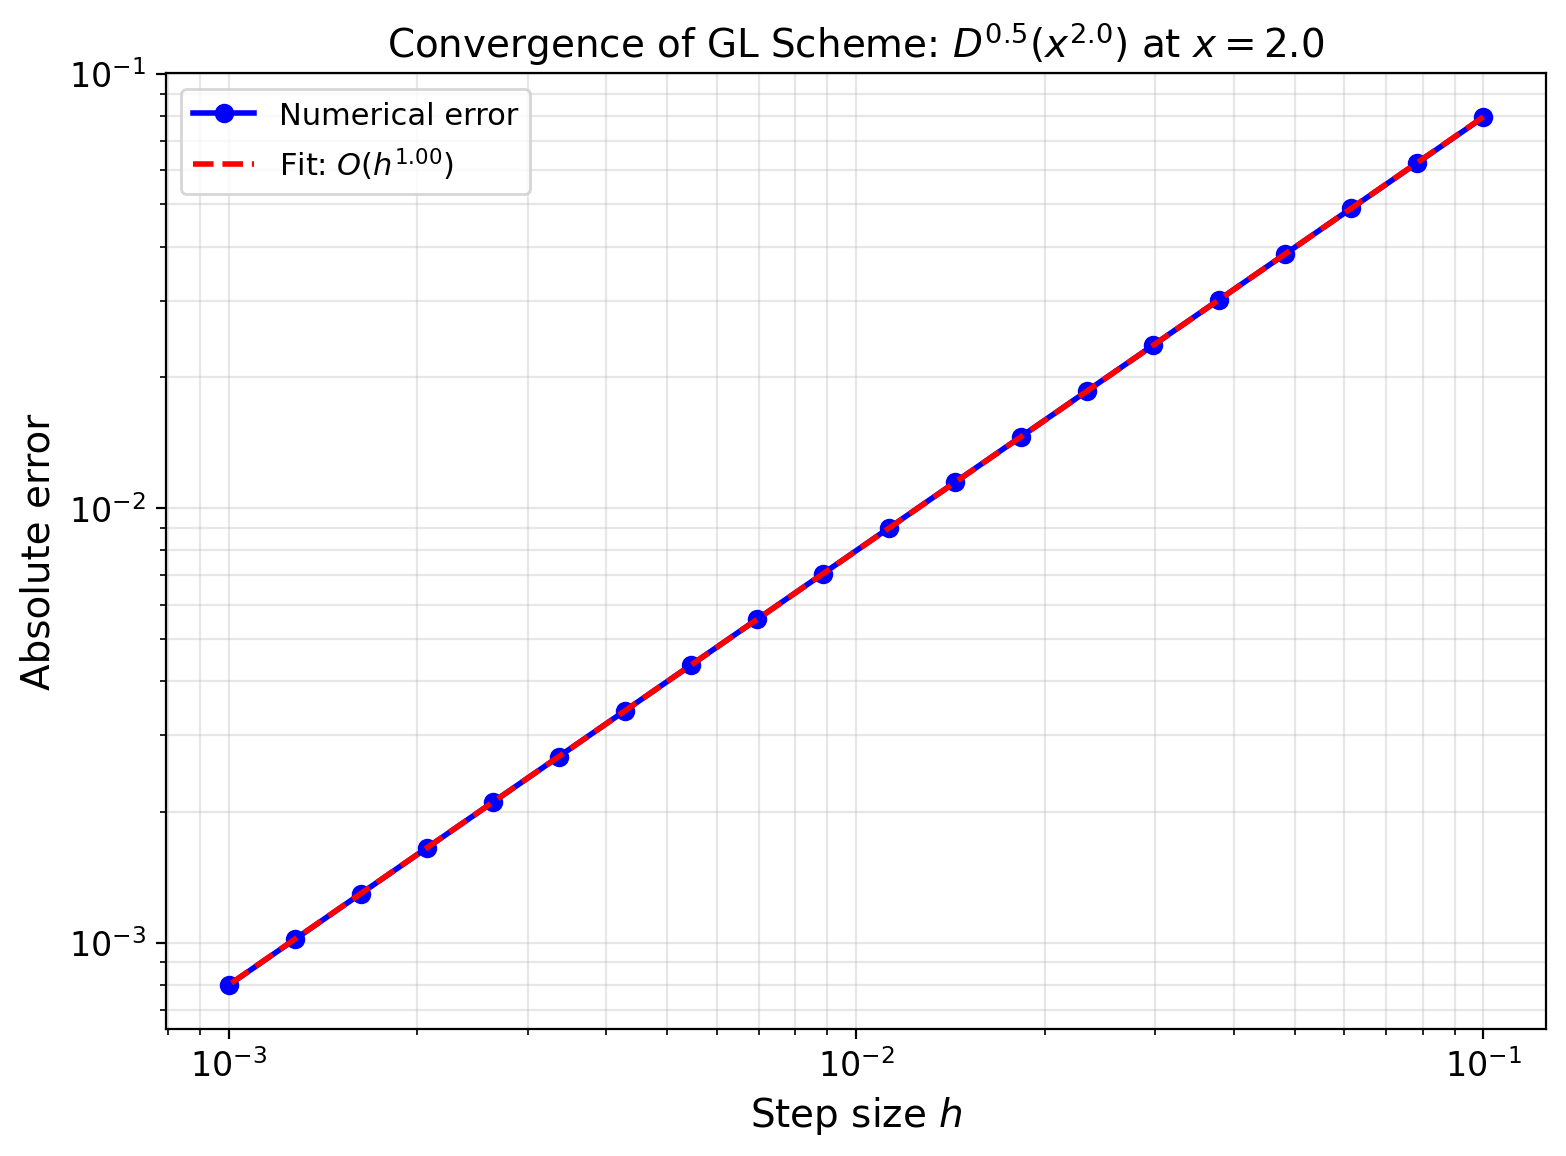


Empirical convergence order: 0.999
Expected order for standard GL scheme: ~1.0


In [5]:
def convergence_study(f, x_eval, alpha, beta, h_values):
    """
    Study convergence of GL approximation for f(x) = x^beta.
    """
    analytical = analytical_power_derivative(x_eval, beta, alpha)
    errors = []
    
    for h in h_values:
        numerical = fractional_derivative_gl(f, x_eval, alpha, h=h)
        errors.append(np.abs(numerical - analytical))
    
    return np.array(errors)


# Convergence test
h_values = np.logspace(-1, -3, 20)
x_eval = 2.0
alpha_test = 0.5
beta_test = 2.0

errors = convergence_study(lambda x: x**beta_test, x_eval, alpha_test, beta_test, h_values)

# Compute convergence rate
log_h = np.log10(h_values)
log_err = np.log10(errors)
slope, intercept = np.polyfit(log_h, log_err, 1)

plt.figure(figsize=(8, 6))
plt.loglog(h_values, errors, 'bo-', linewidth=2, markersize=6, label='Numerical error')
plt.loglog(h_values, 10**intercept * h_values**slope, 'r--', linewidth=2,
           label=f'Fit: $O(h^{{{slope:.2f}}})$')

plt.xlabel('Step size $h$')
plt.ylabel('Absolute error')
plt.title(f'Convergence of GL Scheme: $D^{{{alpha_test}}}(x^{{{beta_test}}})$ at $x={x_eval}$')
plt.legend()
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nEmpirical convergence order: {slope:.3f}")
print("Expected order for standard GL scheme: ~1.0")

## Summary and Key Insights

### Main Takeaways

1. **Fractional derivatives interpolate** between integer orders, providing a continuous spectrum of differentiation operators.

2. **Three main definitions**:
   - **Riemann-Liouville**: Fundamental definition based on fractional integration followed by integer differentiation
   - **Grünwald-Letnikov**: Discrete approximation ideal for numerical computation
   - **Caputo**: Preferred for initial value problems since ${}^{C}D^\alpha c = 0$ for constants

3. **Memory effects**: Fractional operators are *nonlocal* — they depend on the entire history of the function, not just local behavior. This captures memory-dependent phenomena in physical systems.

4. **Power-law decay**: Solutions to fractional differential equations exhibit power-law (algebraic) decay rather than exponential decay, modeling anomalous relaxation processes.

### Formulas Worth Remembering

| Function $f(x)$ | $D^\alpha f(x)$ |
|:---------------:|:---------------:|
| $x^\beta$ | $\frac{\Gamma(\beta+1)}{\Gamma(\beta-\alpha+1)} x^{\beta-\alpha}$ |
| $e^{\lambda x}$ | $\lambda^\alpha e^{\lambda x}$ (for RL with $a=-\infty$) |
| constant $c$ | $\frac{c \cdot x^{-\alpha}}{\Gamma(1-\alpha)}$ (RL) or $0$ (Caputo) |

### Further Reading

- Podlubny, I. (1999). *Fractional Differential Equations*. Academic Press.
- Oldham, K. B., & Spanier, J. (1974). *The Fractional Calculus*. Academic Press.
- Diethelm, K. (2010). *The Analysis of Fractional Differential Equations*. Springer.